In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from transformers import ViTForImageClassification, ViTMAEConfig, ViTConfig, ViTMAEModel, ViTImageProcessor, TrainingArguments, Trainer
from PIL import Image
import matplotlib.pyplot as plt
import requests
from datasets import load_dataset
import torch
import numpy as np
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
import logging 

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device


/home/jiachenyuan/miniconda3/envs/cs444env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda:0'

In [ ]:
logging.basicConfig(level=logging.DEBUG, filename='logs/train.log', filemode='w', format='%(message)s')

In [2]:
model = ViTForImageClassification.from_pretrained('facebook/vit-mae-base', num_labels=10)
# Turn off the masking mechanism, we need full image for downstream application
# model.config.mask_ratio = 0.0
processor = ViTImageProcessor.from_pretrained('facebook/vit-mae-base')
# print(processor)
processor.do_rescale = False
processor

You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/vit-mae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": false,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [3]:
transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ]
)

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          shuffle=True, num_workers=4)

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# class ViTMAEImageClassification(nn.Module):
#     def __init__(self, mae_model, num_labels):
#         super().__init__()
#         self.mae_model = mae_model
#         # Add a classifier head: a linear layer for classification
#         self.classifier_head = nn.Linear(mae_model.config.hidden_size, num_labels)
        

#     def forward(self, pixel_values, **kwargs):
#         # Use the MAE model's forward method
#         outputs = self.mae_model(pixel_values, **kwargs)
        
#         # Assuming outputs.last_hidden_state[:, 0] gives the [CLS] token representation
#         cls_output = outputs.last_hidden_state[:, 0]

#         # Pass the [CLS] token representation through the classifier head
#         logits = self.classifier_head(cls_output)
        
#         return logits

# # Set number of labels
# num_labels = 10
# model = ViTMAEImageClassification(mae_model=model, num_labels=num_labels)



# Fix ViTMAE weights, only leave fc layer trainable
# for param in model.parameters():
#     param.requires_grad = False
# for name, param in model.classifier.named_parameters():
#     param.requires_grad = True

# Check if only the last layer is tunable
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)


model = model.to(device)

vit.embeddings.cls_token
vit.embeddings.position_embeddings
vit.embeddings.patch_embeddings.projection.weight
vit.embeddings.patch_embeddings.projection.bias
vit.encoder.layer.0.attention.attention.query.weight
vit.encoder.layer.0.attention.attention.query.bias
vit.encoder.layer.0.attention.attention.key.weight
vit.encoder.layer.0.attention.attention.key.bias
vit.encoder.layer.0.attention.attention.value.weight
vit.encoder.layer.0.attention.attention.value.bias
vit.encoder.layer.0.attention.output.dense.weight
vit.encoder.layer.0.attention.output.dense.bias
vit.encoder.layer.0.intermediate.dense.weight
vit.encoder.layer.0.intermediate.dense.bias
vit.encoder.layer.0.output.dense.weight
vit.encoder.layer.0.output.dense.bias
vit.encoder.layer.0.layernorm_before.weight
vit.encoder.layer.0.layernorm_before.bias
vit.encoder.layer.0.layernorm_after.weight
vit.encoder.layer.0.layernorm_after.bias
vit.encoder.layer.1.attention.attention.query.weight
vit.encoder.layer.1.attention.attention.query

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
num_epochs = 20
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)


In [6]:
def evaluate_model(loader):
    num_correct = 0
    total = 0
    eval_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(loader, 0), total=len(loader)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = processor(inputs, return_tensors='pt')
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(**inputs)
            outputs = outputs.logits

            loss = criterion(outputs, labels)
            eval_loss += loss.item()
            prediction = outputs.argmax(dim=-1)

            total += prediction.size(0)
            num_correct += (prediction == labels).sum().item()


    # print('Finished eval')
    # print('correctness: ', (num_correct / total * 100).item(), '%')
    return eval_loss/len(loader), num_correct / total


In [7]:
train_losses = []
test_losses = []
test_acc = []

In [8]:
# Train
train_loss_count_freq = 100
test_loss_min = np.Inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    model.train()
    running_train_loss = 0.0
    train_loss_buffer = []
    for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = processor(inputs, return_tensors='pt')
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(**inputs)
        outputs = outputs.logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss_buffer.append(loss.item())
        if i % train_loss_count_freq == (train_loss_count_freq - 1):
            mean_train_loss = np.mean(train_loss_buffer)
            logging.debug(f'[{epoch + 1}, {i + 1:5d}] train loss: {mean_train_loss}')
            train_losses.append(mean_train_loss)
            train_loss_buffer.clear()

    # Evaluate on validation and test set
    model.eval()
    test_loss, correctness_test = evaluate_model(testloader)

    test_losses.append(test_loss)
    test_acc.append(correctness_test)
    # avg_train_loss = 0.0    
    logging.debug(f'[{epoch + 1}, {i + 1:5d}] train loss: {train_losses[-1]:.3f}, valid_loss: {test_loss:.3f}, acc: {correctness_test*100}%, lr={optimizer.param_groups[0]["lr"]}')

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        logging.debug('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        test_loss_min,
        test_loss))
        
        torch.save(model.state_dict(), 'model_cifar.pt')
        test_loss_min = test_loss

    train_losses_t = np.array(train_losses)
    test_losses_t = np.array(test_losses)
    np.save('train_losses.npy', train_losses_t)
    np.save('test_losses.npy', test_losses_t)
    np.save('test_correctness.npy', test_acc)

    scheduler.step()

print('Finished Training')

  0%|          | 0/3125 [00:00<?, ?it/s]/home/jiachenyuan/miniconda3/envs/cs444env/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 625/625 [01:01<00:00, 10.09it/s]

Finished Training


In [9]:
model.load_state_dict(torch.load('model_cifar.pt'))
model.to(device)
evaluate_model(testloader)

  2%|▏         | 15/625 [00:01<00:55, 10.99it/s]

100%|██████████| 625/625 [01:02<00:00,  9.98it/s]


(0.10541145385550335, 0.9717)

In [7]:
print(len(train_losses), len(test_losses))

620 21


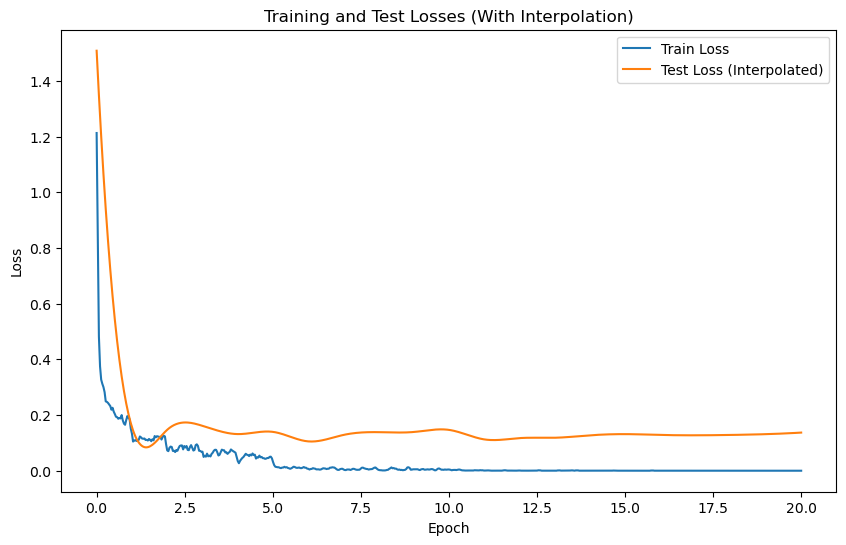

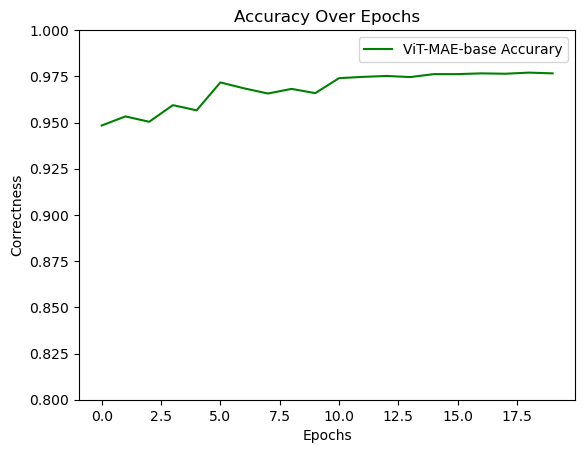

In [4]:
from scipy.interpolate import interp1d
from scipy.ndimage import uniform_filter1d

train_losses = np.load('train_losses.npy')
test_losses = np.load('test_losses.npy')
test_acc = np.load('test_correctness.npy')

window_size = 3
train_losses_smoothed = uniform_filter1d(train_losses, size=window_size, mode='reflect')
test_losses = np.insert(test_losses, 0, train_losses[0])
len_train_losses = len(train_losses)
len_test_losses = len(test_losses)
# Interpolating the test losses
x_rescaled = np.linspace(0, 20, num=len_train_losses)
x_test = np.linspace(0, len_train_losses-1, num=len_test_losses) # Original x-axis for test losses
f = interp1d(x_test, test_losses, kind='cubic')
x_new = np.arange(0, len_train_losses) # New x-axis for interpolated test losses
test_losses_interp = f(x_new)

# Plotting the interpolated test losses with the train losses
plt.figure(figsize=(10, 6))
plt.plot(x_rescaled, train_losses_smoothed, label='Train Loss')
plt.plot(x_rescaled, test_losses_interp, label='Test Loss (Interpolated)')
plt.title('Training and Test Losses (With Interpolation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.xlim(0, 10)
plt.legend()
plt.show()

# # Plotting the accuracy
# plt.figure(figsize=(10, 6))
# test_acc = np.insert(test_acc, 0, 0.75)
# f_acc = interp1d(x_test, test_acc, kind='cubic')
# test_acc_interp = f_acc(x_new)


# print(len(x_rescaled), len(test_acc_interp))
window_size = 1  
test_correctness_smoothed = uniform_filter1d(test_acc, size=window_size, mode='nearest')
# print(test_correctness_smoothed)
plt.plot(test_correctness_smoothed, label='ViT-MAE-base Accurary', color='green')
# Adding title and labels
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Correctness')
plt.ylim(0.8, 1)

# Adding legend
plt.legend()

# Show the plot
plt.show()


